[![](https://shop.googlemerchandisestore.com/store/20160512512/assets/themes/theme1_en/images/logo2.png)]

# About this notebook

In this notebook I show the complete process of reading the files, data cleaning, feature engeneering, running the model and result output. Included is only the final model, all tested ones are in a separate notebook. Visualizations I used for the presentation can also be found in a separate notebook. The 'README' file contains all the necessary links and a detailed task description.

# Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np

# preprocessing
from datetime import datetime, timedelta
import json
from pandas.io.json import json_normalize
import os 
import warnings
warnings.filterwarnings("ignore")
import gc
gc.enable()
from sklearn import preprocessing
pd.options.display.max_columns = None 
import missingno as msno

# modeling
from scipy import stats
import statsmodels.api as sms
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report 
from sklearn import tree
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sn

# plotting
import plotly
from matplotlib import pyplot
import matplotlib.pylab as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
from plotly.offline import *
from matplotlib.colors import ListedColormap

# Import dataset

[download the dataset](https://www.kaggle.com/c/ga-customer-revenue-prediction/data)

There are two large data sets and one file in the correct format to upload the results.

- train_v2.csv (23.67 GB) - contains user transactions from August 1st 2016 to April 30th 2018
- test_v2.csv (7.09 GB) - contains user transactions from May 1st 2018 to October 15th 2018
- sample_submission_v2.csv (6.75 MB) - contains all fullVisitorIds in test_v2.csv



Many thanks to Changhao Lee for sharing his solution:
https://www.kaggle.com/leechh/a-way-to-input-all-columns-include-hits

I change the chunksize to be able to import the data on the MacBook.

In [ ]:
# import in small packages and transform json columns
def todict(dic, key, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key] = [value]
    return dic


def resolve_json(hitsdic, hits_json, key='NoneName'):
    if type(hits_json) == list:
        if len(hits_json) == 0:
            pass
        else:
            for subjson in hits_json:
                hitsdic = resolve_json(hitsdic, subjson)
    elif type(hits_json) == dict:
        for i in hits_json.keys():
            hitsdic = resolve_json(hitsdic, hits_json[i],i)
    else:
        hitsdic = todict(hitsdic, key, hits_json)
    return hitsdic


def complex_replace(x):
    dic = {}
    return resolve_json(dic, json.loads(x.replace('\'','\"'). \
                                        replace('TRUE','true'). \
                                        replace('True','true'). \
                                        replace('FALSE','false'). \
                                        replace('False','false'). \
                                        replace(', \"',', !&~'). \
                                        replace('\", ','!&~, '). \
                                        replace('\": ','!&~: '). \
                                        replace(': \"',': !&~'). \
                                        replace(' {\"',' {!&~'). \
                                        replace('\"}, ','!&~}, '). \
                                        replace('[{\"','[{!&~'). \
                                        replace('\"}]','!&~}]'). \
                                        replace('\"','_'). \
                                        replace('!&~','\"'). \
                                        encode('gbk','ignore'). \
                                        decode('utf-8','ignore'). \
                                        replace('\\','')))


def replace(x):
    return  json.loads(x)


def load_df(csv_path, nrows=None, chunksize=10_000, percent=100):
    n=1
    df_list = []
    feature = ['device', 'hits', 'customDimensions', 'geoNetwork', 'totals', 'trafficSource']
    chunk = pd.read_csv(csv_path,
                        nrows=nrows, 
                        chunksize=chunksize, 
                        dtype={'fullVisitorId': 'str'}) # Important!!
    for subchunk in chunk:
        for column in feature:
            if column in ['customDimensions','hits']:
                column_as_df = json_normalize(subchunk[column].apply(complex_replace))
            else:
                column_as_df = json_normalize(subchunk[column].apply(replace))
            column_as_df.columns = [f'{column}_{subcolumn}' for subcolumn in column_as_df.columns]
            subchunk.drop(column, axis=1, inplace=True)
            subchunk = subchunk.reset_index(drop=True).merge(column_as_df,
                                           right_index=True,
                                           left_index=True)
        n = n+1
        df_list.append(subchunk.astype('str'))
        del column_as_df, subchunk
    return pd.concat(df_list, ignore_index=True, sort=True)

In [ ]:
# import train data
train = load_df('data/train_v2.csv',nrows=None, chunksize=10000)

In [ ]:
# import test data
test = load_df('data/test_v2.csv',nrows=None, chunksize=10000)

In [ ]:
# the import takes a few hours, so better export the formatted data as csv
train.to_csv('new_train.csv', index=False)
test.to_csv('new_test.csv', index=False)

**new file sizes**
- new_train.csv (11.1 GB)
- new_test.csv (3.2 GB)

# Data cleaning

In [2]:
# i zipped the original files and restarted the Mac. 
# import new files, we need the 'fullVisitorId' as a string for uploading the solution on kaggle
df_train = pd.read_csv("data/new_train.csv", dtype = {"fullVisitorId" : "str"})
df_test = pd.read_csv("data/new_test.csv", dtype = {"fullVisitorId" : "str"})

In [3]:
# in total 2.1 million rows and 148 columns
print('Train-Data:', df_train.shape) 
print('Test-Data: ',df_test.shape)

Train-Data: (1708337, 148)
Test-Data:  (401589, 147)


## Explore columns one by one


Detailed description of the variables: [Google Analytics](https://support.google.com/analytics/answer/3437719?hl=de)

- **fullVisitorId** - A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping** - The channel via which the user came to the Store.
- **date** - The date on which the user visited the Store.
- **device** - The specifications for the device used to access the Store.
- **geoNetwork** - This section contains information about the geography of the user.
- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals** - This section contains aggregate values across the session.
- **trafficSource** - This section contains information about the Traffic Source from which the session originated.
- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime** - The timestamp (expressed as POSIX time).
- **hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- **customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- **totals** - This set of columns mostly includes high-level aggregate data.

In [4]:
# at first sight we see many missing values
df_train.tail(3)

,channelGrouping,customDimensions_index,customDimensions_value,date,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,fullVisitorId,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,hits_action_type,hits_affiliation,hits_contentGroup1,hits_contentGroup2,hits_contentGroup3,hits_contentGroup4,hits_contentGroup5,hits_contentGroupUniqueViews1,hits_contentGroupUniqueViews2,hits_contentGroupUniqueViews3,hits_currencyCode,hits_dataSource,hits_domContentLoadedTime,hits_domInteractiveTime,hits_domLatencyMetricsSample,hits_domainLookupTime,hits_eventAction,hits_eventCategory,hits_eventLabel,hits_exitScreenName,hits_hasSocialSourceReferral,hits_hitNumber,hits_hostname,hits_hour,hits_isClick,hits_isEntrance,hits_isExit,hits_isFatal,hits_isImpression,hits_isInteraction,hits_landingScreenName,hits_localProductPrice,hits_localProductRevenue,hits_localTransactionRevenue,hits_localTransactionShipping,hits_localTransactionTax,hits_minute,hits_option,hits_pageDownloadTime,hits_pageLoadSample,hits_pageLoadTime,hits_pagePath,hits_pagePathLevel1,hits_pagePathLevel2,hits_pagePathLevel3,hits_pagePathLevel4,hits_pageTitle,hits_previousContentGroup1,hits_previousContentGroup2,hits_previousContentGroup3,hits_previousContentGroup4,hits_previousContentGroup5,hits_productBrand,hits_productCouponCode,hits_productListName,hits_productListPosition,hits_productPrice,hits_productQuantity,hits_productRevenue,hits_productSKU,hits_productVariant,hits_promoCreative,hits_promoId,hits_promoIsClick,hits_promoIsView,hits_promoName,hits_promoPosition,hits_redirectionTime,hits_referer,hits_screenDepth,hits_screenName,hits_searchCategory,hits_searchKeyword,hits_serverConnectionTime,hits_serverResponseTime,hits_socialInteractionNetworkAction,hits_socialNetwork,hits_speedMetricsSample,hits_step,hits_time,hits_transactionCoupon,hits_transactionId,hits_transactionRevenue,hits_transactionShipping,hits_transactionTax,hits_type,hits_v2ProductCategory,hits_v2ProductName,socialEngagementType,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime
1708334,Social,NaN,NaN,20170104,Android Webview,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,5744576632396406899,Seoul,not available in demo dataset,Asia,South Korea,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Seoul,Eastern Asia,"['0', '0', '0', '0', '0', '1', '2', '0', '0', ...",NaN,"['(not set)', '(not set)', '(not set)', '(not ...","['(not set)', '(not set)', 'Apparel', '(not se...","['(not set)', '(not set)', '(not set)', '(not ...","['(not set)', '(not se

The meaning of the individual columns is not always clear.
For a better understanding I took a beginners course online at the **Google Analytics Academy**. 
The content of the columns does not always seem to be consistent either. e.g. 'geoNetwork_region' contains the values 'Seol' and 'not available in demo dataset'

In [89]:
df_train.geoNetwork_region[1708334:1708336]

1708334                            Seoul
1708335    not available in demo dataset
Name: geoNetwork_region, dtype: object

### Identify columns with single values and drop these

In [5]:
# get columns with single value
uniques = df_train.nunique(dropna=False).to_frame()
uniques['name'] = uniques.index
uniques = uniques.reset_index(drop=True)
unique_one = uniques.loc[uniques[0] == 1]
drop_list = list(unique_one.name)
print('No. of useless columns: ',len(drop_list))

No. of useless columns:  19


In [6]:
# drop 19 columns without any information
df_train.drop(drop_list, axis=1, inplace=True)

In [7]:
# same on the test data
uniques = df_test.nunique(dropna=False).to_frame()
uniques['name'] = uniques.index
uniques = uniques.reset_index(drop=True)
unique_one = uniques.loc[uniques[0] == 1]
drop_list = list(unique_one.name)
df_test.drop(drop_list, axis=1, inplace=True)

In [8]:
df_test.shape

(401589, 128)

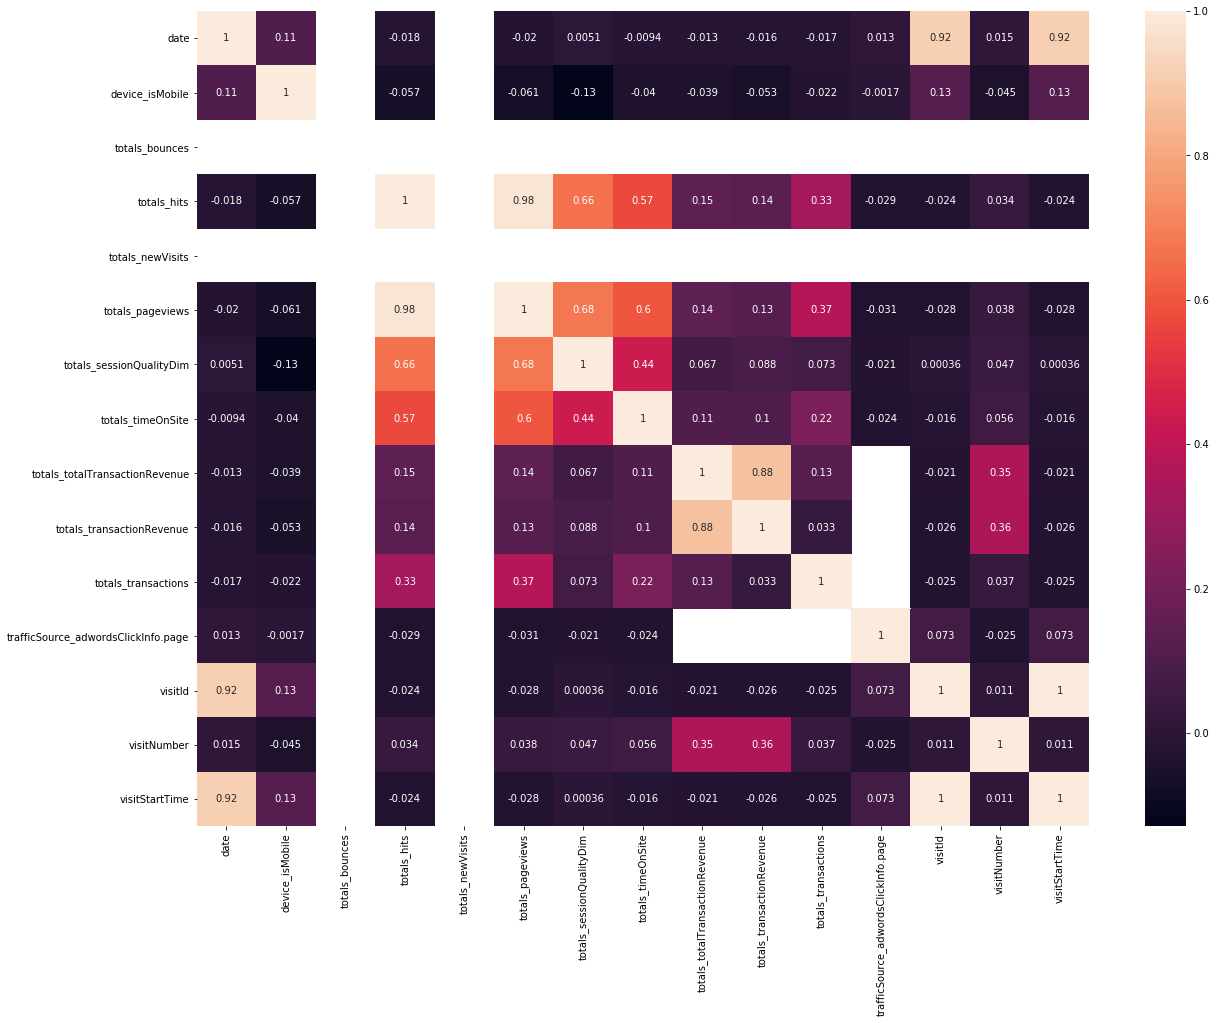

In [9]:
# visitId = visitStartTime
corr = df_train.corr()
plt.subplots(figsize=(20,15))
sn.heatmap(corr, annot=True);

In [10]:
# Unique elements per column
df_train.nunique()

channelGrouping                                       8
customDimensions_index                                1
customDimensions_value                                5
date                                                638
device_browser                                      129
device_deviceCategory                                 3
device_isMobile                                       2
device_operatingSystem                               24
fullVisitorId                                   1323730
geoNetwork_city                                     956
geoNetwork_continent                                  6
geoNetwork_country                                  228
geoNetwork_metro                                    123
geoNetwork_networkDomain                          41982
geoNetwork_region                                   483
geoNetwork_subContinent                              23
hits_action_type                                 105042
hits_affiliation                                

**Let's make the data set more clearer.**

In [86]:
# missing values, not informative or information in other columns
columns2drop = ['customDimensions_index', 'device_isMobile','hits_dataSource', 'hits_currencyCode',
        'hits_contentGroup4', 'hits_contentGroup5', 'hits_contentGroupUniqueViews1',
        'hits_contentGroupUniqueViews2', 'hits_contentGroupUniqueViews3', 'hits_domLatencyMetricsSample',
        'hits_hasSocialSourceReferral','hits_hitNumber', 'hits_hostname', 'hits_hour', 'hits_isClick', 
        'hits_isEntrance', 'hits_isExit', 'hits_isFatal', 'hits_isImpression', 'hits_isInteraction',
        'hits_localProductPrice', 'hits_localProductRevenue', 'hits_localTransactionRevenue',
        'hits_localTransactionShipping', 'hits_localTransactionTax', 'hits_minute', 'hits_option', 
        'hits_pageDownloadTime', 'hits_pageLoadSample', 'hits_pageLoadTime', 'hits_pagePath', 
        'hits_pagePathLevel1', 'hits_pagePathLevel2', 'hits_pagePathLevel3', 'hits_pagePathLevel4',
        'hits_previousContentGroup1', 'hits_previousContentGroup2', 'hits_previousContentGroup3', 
        'hits_previousContentGroup4', 'hits_previousContentGroup5', 'hits_productBrand', 
        'hits_productCouponCode', 'hits_productListName', 'hits_productListPosition', 'hits_productVariant',
        'hits_promoId', 'hits_promoPosition', 'hits_redirectionTime', 'hits_referer', 'hits_screenDepth', 
        'hits_screenName', 'hits_searchCategory', 'hits_serverConnectionTime', 'hits_serverResponseTime',
        'hits_socialInteractionNetworkAction', 'hits_speedMetricsSample', 'hits_step', 'hits_time', 
        'hits_transactionId', 'hits_transactionTax', 'hits_type', 'hits_v2ProductCategory', 'hits_v2ProductName',
        'customDimensions_value', 'hits_action_type', 'hits_contentGroup1', 'hits_contentGroup2', 
        'hits_contentGroup3', 'hits_affiliation', 'hits_domContentLoadedTime', 'hits_domInteractiveTime', 
        'hits_domainLookupTime', 'totals_totalTransactionRevenue', 'hits_eventAction', 'hits_eventCategory', 
        'hits_exitScreenName', 'hits_landingScreenName', 'hits_pageTitle', 'hits_productPrice', 
        'hits_productQuantity', 'hits_productRevenue', 'hits_productSKU', 'hits_promoCreative', 
        'hits_promoIsView', 'hits_promoName', 'hits_searchKeyword', 'hits_socialNetwork', 'hits_transactionRevenue',
        'hits_transactionShipping', 'totals_totalTransactionRevenue', 'visitId', 
        'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.gclId',
        'totals_timeOnSite', 'hits_eventLabel']
print('columns to drop:',len(columns2drop))

columns to drop: 96


In [13]:
# drop 96 columns wich are not necessary for prediction, some of them may used for EDA.
df_train.drop(columns2drop, axis=1, inplace=True)
df_test.drop(columns2drop, axis=1, inplace=True)

In [14]:
# 34 to 33 columns
df_train.shape, df_test.shape

((1708337, 34), (401589, 33))

In [15]:
# where is the difference?
train_c = df_train.columns
test_c = df_test.columns
train_c.symmetric_difference(test_c)

Index(['trafficSource_campaignCode'], dtype='object')

In [16]:
df_train.trafficSource_campaignCode.unique()

array([nan, '11251kjhkvahf'], dtype=object)

In [17]:
# no need for 'trafficSource_campaignCode'
df_train.drop('trafficSource_campaignCode', axis=1, inplace=True)

In [18]:
# now the data set looks workable
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 33 columns):
channelGrouping                                 object
date                                            int64
device_browser                                  object
device_deviceCategory                           object
device_operatingSystem                          object
fullVisitorId                                   object
geoNetwork_city                                 object
geoNetwork_continent                            object
geoNetwork_country                              object
geoNetwork_metro                                object
geoNetwork_networkDomain                        object
geoNetwork_region                               object
geoNetwork_subContinent                         object
hits_promoIsClick                               object
hits_transactionCoupon                          object
totals_bounces                                  float64
totals_

In [19]:
# Store the data again
df_train.to_csv('train_red.csv', index=False)
df_test.to_csv('test_red.csv', index=False)

In [63]:
# Import
df_train = pd.read_csv("train_red.csv", dtype = {"fullVisitorId" : "str", "hits_transactionCoupon" : "str"})
df_test = pd.read_csv("test_red.csv", dtype = {"fullVisitorId" : "str", "hits_transactionCoupon" : "str"})

## Convert columns

In [64]:
# Convert column containing '.' names for easier processing
df_train.rename(columns = {'trafficSource_adwordsClickInfo.slot':'trafficSource_adwordsClickInfo_slot',
                    'trafficSource_adwordsClickInfo.page':'trafficSource_adwordsClickInfo_page', 
                    'trafficSource_adwordsClickInfo.adNetworkType':'trafficSource_adwordsClickInfo_adNetworkType',
                    }, inplace = True)
df_test.rename(columns = {'trafficSource_adwordsClickInfo.slot':'trafficSource_adwordsClickInfo_slot',
                    'trafficSource_adwordsClickInfo.page':'trafficSource_adwordsClickInfo_page', 
                    'trafficSource_adwordsClickInfo.adNetworkType':'trafficSource_adwordsClickInfo_adNetworkType',
                    }, inplace = True)

In [65]:
# Convert datetime
df_train["date"] = pd.to_datetime(df_train["date"], infer_datetime_format=True, format="%Y%m%d")
df_train['visitStartTime'] = pd.to_datetime(df_test['visitStartTime'], unit='s')
df_test["date"] = pd.to_datetime(df_test["date"], infer_datetime_format=True, format="%Y%m%d")
df_test['visitStartTime'] = pd.to_datetime(df_test['visitStartTime'], unit='s')

In [66]:
# 'hits_promoIsClick'
df_train['hits_promoClick'] = df_train.hits_promoIsClick.str.contains('True')
df_train.fillna({'hits_promoClick': False}, inplace=True)
df_test['hits_promoClick'] = df_test.hits_promoIsClick.str.contains('True')
df_test.fillna({'hits_promoClick': False}, inplace=True)

## Dealing with missing values

In [67]:
# Let's see the ratio of missing values
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total / len(df) 
    return pd.concat([total,percent], axis=1, keys =['Total', 'Percent'])
missing = missing_data(df_train)
missing.head(17)

,Total,Percent
hits_transactionCoupon,1708095,0.999858
totals_transactionRevenue,1689823,0.989163
totals_transactions,1689778,0.989136
hits_promoIsClick,1669615,0.977334
trafficSource_adContent,1643600,0.962105
trafficSource_adwordsClickInfo_adNetworkType,1633063,0.955937
trafficSource_adwordsClickInfo_page,1633063,0.955937
trafficSource_adwordsClickInfo_slot,1633063,0.955937
visitStartTime,1306748,0.764924
trafficSource_isTrueDirect,1173819,0.687112


### Dendogram

The dendrogram uses a hierarchical clustering algorithm to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero.

e.g. **'totals_transactions**' and  **'totals_transactionRevenue'** are realy close.

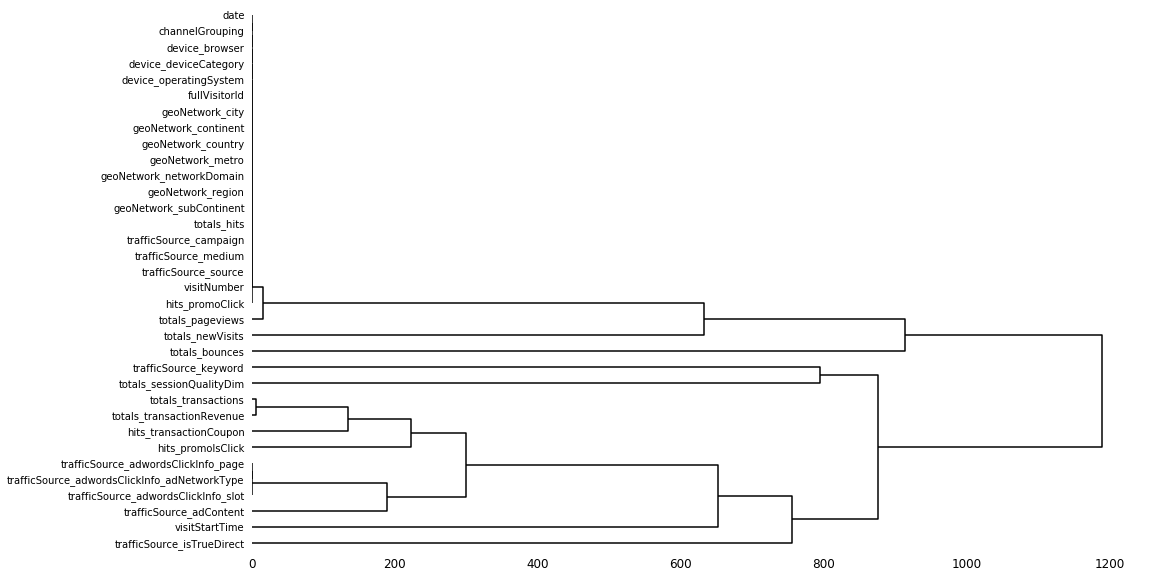

In [85]:
msno.dendrogram(df_train, orientation='right', fontsize=10, figsize=(16,10));

In [26]:
# after some more explorations, filling missing values
df_train.fillna({'totals_transactionRevenue': 0, 'totals_transactions': 0, 'trafficSource_adwordsClickInfo_page': 0,
          'totals_bounces': 0, 'totals_newVisits': 0, 'hits_promoIsClick': False, 
          'trafficSource_isTrueDirect': False, 'hits_transactionCoupon': 'None', 
          'trafficSource_adContent': 'None', 'trafficSource_adwordsClickInfo_adNetworkType': 'None',
          'trafficSource_adwordsClickInfo_slot': 'None', 'trafficSource_keyword': '(not provided)',
          'totals_sessionQualityDim': 1}, inplace=True)

df_test.fillna({'totals_transactionRevenue': 0, 'totals_transactions': 0, 'trafficSource_adwordsClickInfo_page': 0,
          'totals_bounces': 0, 'totals_newVisits': 0, 'hits_promoIsClick': False, 
          'trafficSource_isTrueDirect': False, 'hits_transactionCoupon': 'None', 
          'trafficSource_adContent': 'None', 'trafficSource_adwordsClickInfo_adNetworkType': 'None',
          'trafficSource_adwordsClickInfo_slot': 'None', 'trafficSource_keyword': '(not provided)',
          'totals_sessionQualityDim': 1}, inplace=True)

In [27]:
# 'hits_transactionCoupon'
df_train['hits_transactionCoupon'] = df_train['hits_transactionCoupon'].str[4:]
df_train['hits_Coupon'] = df_train['hits_transactionCoupon'].apply(lambda x: x.split(',')[0])
df_train['hits_Coupon'] = df_train['hits_Coupon'].str.replace("'", '')
df_train['hits_Coupon'] = df_train['hits_Coupon'].str.replace('"', '')
df_train['hits_Coupon'] = df_train['hits_Coupon'].str.replace('ne', '')
df_test['hits_transactionCoupon'] = df_test['hits_transactionCoupon'].str[4:]
df_test['hits_Coupon'] = df_test['hits_transactionCoupon'].apply(lambda x: x.split(',')[0])
df_test['hits_Coupon'] = df_test['hits_Coupon'].str.replace("'", '')
df_test['hits_Coupon'] = df_test['hits_Coupon'].str.replace('"', '')
df_test['hits_Coupon'] = df_test['hits_Coupon'].str.replace('ne', '')

In [28]:
# drop columns
df_train.drop(['hits_transactionCoupon', 'hits_promoIsClick'], axis=1, inplace=True)
df_test.drop(['hits_transactionCoupon', 'hits_promoIsClick'], axis=1, inplace=True)

In [29]:
# using 'hits' to fill pageviews
df_train.loc[df_train['totals_pageviews'].isnull(),'totals_pageviews'] = df_train['totals_hits']
df_test.loc[df_test['totals_pageviews'].isnull(),'totals_pageviews'] = df_test['totals_hits']

## Label encoding categorical variables

In [30]:
# categorical variables
categorical = ["channelGrouping", "device_browser", "device_deviceCategory", "device_operatingSystem", 
            "geoNetwork_city", "geoNetwork_continent", "geoNetwork_country", "geoNetwork_metro",
            "hits_Coupon", "geoNetwork_networkDomain", "geoNetwork_region", "geoNetwork_subContinent", 
            "trafficSource_adContent", "trafficSource_campaign",
            "trafficSource_adwordsClickInfo_slot", "trafficSource_keyword", "trafficSource_medium", 
            "trafficSource_source", "trafficSource_adwordsClickInfo_adNetworkType"]

In [31]:
# encodeing train data
for col in categorical:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
hits_Coupon
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_campaign
trafficSource_adwordsClickInfo_slot
trafficSource_keyword
trafficSource_medium
trafficSource_source
trafficSource_adwordsClickInfo_adNetworkType


In [32]:
# encodeing test data
for col in categorical:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_test[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
hits_Coupon
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_campaign
trafficSource_adwordsClickInfo_slot
trafficSource_keyword
trafficSource_medium
trafficSource_source
trafficSource_adwordsClickInfo_adNetworkType


In [33]:
# Export as csv again...
df_train.to_csv('train_processed.csv', index=False)
df_test.to_csv('test_processed.csv', index=False)

# Aggregating by 'fullVisitorId' 

The test data set contains a period of 168 days, the last day is 15 October 2018, and for each fullvisitorID included, sales are to be forecast for the period December to January (62 days). The 46 days between the test data record and the forecast period are not known and should not be forecast. In the following function, the periods are transferred to the training data.
Inspired by: [HuanZhang999](https://github.com/HuanZhang999/GoogleAnalyticsCustomerRevenuePrediction/blob/master/1-%20create_train.ipynb)

In [34]:
# K 1-4 to split dataset in pieces of 168 days
def getTimeFramewithFeatures(df, k=1):
    tf = df.loc[(df['date'] >= min(df['date']) + timedelta(days=168*(k-1))) 
              & (df['date'] < min(df['date']) + timedelta(days=168*k))]
    
    # get fullVisitorIds out of the predicted timeframe 
    tf_fvid = set(df.loc[(df['date'] >= min(df['date']) + timedelta(days=168*k + 46 )) 
                       & (df['date'] < min(df['date']) + timedelta(days=168*k + 46 + 62))]['fullVisitorId'])

    tf_returned = tf[tf['fullVisitorId'].isin(tf_fvid)]
    
    # sub dataset of IDs if in predicted timeframe
    tf_sub = df[df['fullVisitorId'].isin(set(tf_returned['fullVisitorId'])) 
             & (df['date'] >= min(df['date']) + timedelta(days=168*k + 46))
             & (df['date'] < min(df['date']) + timedelta(days=168*k + 46 + 62))]
    
    # Calculating target variable (np.log)!                     
    tf_target = tf_sub.groupby('fullVisitorId')[['totals_transactionRevenue']].sum().apply(np.log1p, axis=1).reset_index()
   
    # 1 if visitors have returned
    tf_target['ret'] = 1
    tf_target.rename(columns={'totals_transactionRevenue': 'target'}, inplace=True)
    
    # creating datafram for visitor who havn't returned
    tf_nonret = pd.DataFrame()
    tf_nonret['fullVisitorId'] = list(set(tf['fullVisitorId']) - tf_fvid)
    
    # 0 if visitors havn't returned
    tf_nonret['target'] = 0
    tf_nonret['ret'] = 0
    
    # merge the dataframes from above
    tf_target = pd.concat([tf_target, tf_nonret], axis=0).reset_index(drop=True)
    
    # min and max-date for date based featurs
    tf_maxdate = max(tf['date'])
    tf_mindate = min(tf['date'])
    # creating the features   
    tf = tf.groupby('fullVisitorId').agg({
            'geoNetwork_networkDomain': {'networkDomain': lambda x: x.dropna().max()}, 
            'geoNetwork_city': {'city': lambda x: x.dropna().max()},  
            'device_operatingSystem': {'operatingSystem': lambda x: x.dropna().max()},  
            'geoNetwork_metro': {'metro': lambda x: x.dropna().max()},  
            'geoNetwork_region': {'region': lambda x: x.dropna().max()},   
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},  
            'geoNetwork_country': {'country': lambda x: x.dropna().max()},    
            'trafficSource_source': {'source': lambda x: x.dropna().max()},   
            'trafficSource_medium': {'medium': lambda x: x.dropna().max()},   
            'trafficSource_keyword': {'keyword': lambda x: x.dropna().max()}, 
            'device_browser':  {'browser': lambda x: x.dropna().max()},  
            'device_deviceCategory': {'deviceCategory': lambda x: x.dropna().max()}, 
            'geoNetwork_continent': {'continent': lambda x: x.dropna().max()},      
            'totals_pageviews': {'pageviews_sum': lambda x: x.dropna().sum(),     
                                 'pageviews_min': lambda x: x.dropna().min(),     
                                 'pageviews_max': lambda x: x.dropna().max(),     
                                 'pageviews_mean': lambda x: x.dropna().mean()},  
            'totals_hits': {'hits_sum': lambda x: x.dropna().sum(),     
                            'hits_min': lambda x: x.dropna().min(),     
                            'hits_max': lambda x: x.dropna().max(),     
                            'hits_mean': lambda x: x.dropna().mean()},  
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()}, 
            'totals_sessionQualityDim': {'sessionQualityDim': lambda x: x.dropna().max()}, 
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()}, 
            'totals_transactionRevenue':  {'totalTransactionRevenue_sum':  lambda x:x.dropna().sum()}, 
            'totals_transactions' : {'transactions' : lambda x:x.dropna().sum()},
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tf_mindate,
                     'last_ses_from_the_period_end': lambda x: tf_maxdate - x.dropna().max(), 
                     'interval_dates': lambda x: x.dropna().max() - x.dropna().min(), 
                     'unqiue_date_num': lambda x: len(set(x.dropna())) },          
                    })

    # drop the parent level
    tf.columns = tf.columns.droplevel() 
    # merging features and target variables
    tf = pd.merge(tf, tf_target, left_on='fullVisitorId', right_on='fullVisitorId') 
    return tf

In [35]:
# create a timeframe to train the model
%time tr1 = getTimeFramewithFeatures(df_train, k=1)

CPU times: user 51min 36s, sys: 44.5 s, total: 52min 20s
Wall time: 51min 43s


In [36]:
df_test.date.max()

Timestamp('2018-10-15 00:00:00')

In [37]:
### aggregate the test-set analog train-set, but without using any future data
tf_maxdate = max(df_test['date'])  
tf_mindate = min(df_test['date'])    

In [38]:
df_final_test = df_test.groupby('fullVisitorId').agg({
            'geoNetwork_networkDomain': {'networkDomain': lambda x: x.dropna().max()},
            'geoNetwork_city': {'city': lambda x: x.dropna().max()},  
            'device_operatingSystem': {'operatingSystem': lambda x: x.dropna().max()}, 
            'geoNetwork_metro': {'metro': lambda x: x.dropna().max()},  
            'geoNetwork_region': {'region': lambda x: x.dropna().max()},   
            'channelGrouping': {'channelGrouping': lambda x: x.dropna().max()},  
            'geoNetwork_country': {'country': lambda x: x.dropna().max()},    
            'trafficSource_source': {'source': lambda x: x.dropna().max()},   
            'trafficSource_medium': {'medium': lambda x: x.dropna().max()},   
            'trafficSource_keyword': {'keyword': lambda x: x.dropna().max()}, 
            'device_browser':  {'browser': lambda x: x.dropna().max()},
            'device_deviceCategory': {'deviceCategory': lambda x: x.dropna().max()}, 
            'geoNetwork_continent': {'continent': lambda x: x.dropna().max()},      
            'totals_pageviews': {'pageviews_sum': lambda x: x.dropna().sum(),     
                                 'pageviews_min': lambda x: x.dropna().min(),     
                                 'pageviews_max': lambda x: x.dropna().max(),     
                                 'pageviews_mean': lambda x: x.dropna().mean()},  
            'totals_hits': {'hits_sum': lambda x: x.dropna().sum(),     
                            'hits_min': lambda x: x.dropna().min(),     
                            'hits_max': lambda x: x.dropna().max(),     
                            'hits_mean': lambda x: x.dropna().mean()},  
            'visitStartTime': {'visitStartTime_counts': lambda x: x.dropna().count()}, 
            'totals_sessionQualityDim': {'sessionQualityDim': lambda x: x.dropna().max()}, 
            'visitNumber': {'visitNumber_max' : lambda x: x.dropna().max()},  
            'totals_transactionRevenue':  {'totalTransactionRevenue_sum':  lambda x:x.dropna().sum()}, 
            'totals_transactions' : {'transactions' : lambda x:x.dropna().sum()}, 
            'date': {'first_ses_from_the_period_start': lambda x: x.dropna().min() - tf_mindate, 
                     'last_ses_from_the_period_end': lambda x: tf_maxdate - x.dropna().max(), 
                     'interval_dates': lambda x: x.dropna().max() - x.dropna().min(),  
                     'unqiue_date_num': lambda x: len(set(x.dropna())) },        
                    })

df_final_test.columns = df_final_test.columns.droplevel() 

In [39]:
df_final_test.reset_index(level=0, inplace=True)

In [40]:
len(df_final_test)

296530

# Creating X and y

In [41]:
tr1['ret_buyer'] = tr1['target'] > 0
y_class = tr1.pop("ret_buyer")
y_reg = tr1.pop('target')
X = tr1

## Prepare Test Data

In [42]:
df_final_test['first_ses_from_the_period_start'] = df_final_test['first_ses_from_the_period_start'].dt.days.astype('int')
df_final_test['last_ses_from_the_period_end'] = df_final_test['last_ses_from_the_period_end'].dt.days.astype('int')
df_final_test['interval_dates'] = df_final_test['interval_dates'].dt.days.astype('int')

In [43]:
ID_X_sub = df_final_test.pop('fullVisitorId')
df_final_test['ID'] = ID_X_sub.astype('float')

# Train-/Test-Split classification

In [44]:
X['first_ses_from_the_period_start'] = X['first_ses_from_the_period_start'].dt.days.astype('int')
X['last_ses_from_the_period_end'] = X['last_ses_from_the_period_end'].dt.days.astype('int')
X['interval_dates'] = X['interval_dates'].dt.days.astype('int')
ret = X.pop('ret')

In [45]:
# Transform ID in to float and store it for submission
ID_X = X.pop('fullVisitorId')
X['ID'] = ID_X.astype('float')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y_class,random_state=13)

# Modelling classification

## Baseline model

I predict that no one will buy anything.

**Wooow only 34 positivs in a set of nearly 100.000**

At the kaggle competion I would have finished 304th out of 1049. So it's quite good, but after a long test phase I could find a model that works even better.

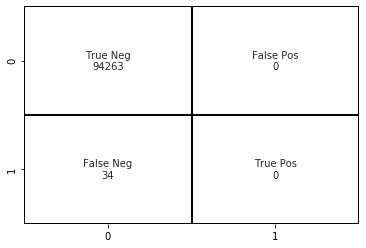

In [47]:
# baseline model all zero
y_baseline = np.zeros(len(y_test))
cf_matrix = confusion_matrix(y_test,y_baseline)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='',linewidths=1, cbar=False, 
           linecolor='black', cmap=ListedColormap(['white']));

## LightGBM

**Why LightGBM?**

It was the first time i used LightGBM. Random Forest, XGBoost and LightGBM achieved comparable results, but at the final test LightGBM was slightly better and the training time was realy fast.

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

Here you can find the LightGBM’s documentation: https://lightgbm.readthedocs.io/en/latest/

In [48]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

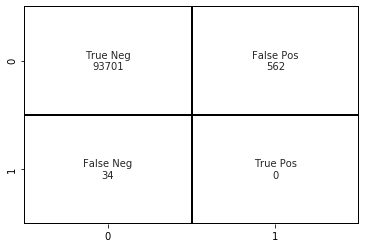

In [49]:
# We need some adjustments
y_pred = model_lgb.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cbar=False, linewidths=1, 
           linecolor='black',cmap=ListedColormap(['white']));

### LightGBM Random Search

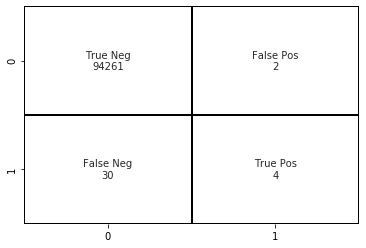

In [60]:
# Create parameters
gridParams = {
    'learning_rate': [0.35],    
    'n_estimators': [100,110],           
    'num_leaves': [16],           
    'boosting_type' : ['dart'],
    'reg_alpha' : [1],                    
    'reg_lambda' : [1],                   
    'objective' : ['binary'],              
    'metric' : ['binary_logloss'],        
    'colsample_bytree' : [0.8],     
    'subsample' : [0.7],             
    'max_leaves': [100,105],           
    'min_child_samples' : [18,20]            
     }
#Define LightGBM Classifier model
model_lgb_gs = lgb.LightGBM()
#RandomizedSearchCV to hypertune the parameters
randCV = RandomizedSearchCV(model_lgb_gs, gridParams,
                    cv=3,
                    n_jobs=1)

# Fit model
randCV.fit(X_train, y_train)
randCV.best_estimator_
best_model_lgb = randCV.best_estimator_
y_pred_lgb = best_model_lgb.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred_lgb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cbar=False, linewidths=1, 
           linecolor='black',cmap=ListedColormap(['white']));

In [51]:
# the best parameters after random search
randCV.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.35, max_depth=-1,
               max_leaves=100, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=16, objective='binary', random_state=None,
               reg_alpha=1, reg_lambda=1, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

### Run adjusted LGBM with Test Data

The model identified five possible buyers

In [52]:
y_pred_sub = best_model_lgb.predict(df_final_test)
y_pred_sub.sum()

5

## Regression with LightGBM

I was running out of time and it is almost impossible to predict if someone will buy at all, so I used a very simple forecasting model for the value. All those who were not predicted as possible buyers remain at zero. 

In [53]:
# we need a new split, because our target variable changed
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X,y_reg,random_state=13)

In [54]:
# Define LightGBM Regressor and train model
model_lgb_reg = lgb.LGBMRegressor()
model_lgb_reg.fit(X_train_reg, y_train_reg)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
# using Test-Data on model
y_pred_reg = model_lgb_reg.predict(df_final_test)

## Create submission file

In [56]:
kaggle = pd.DataFrame()
kaggle['fullVisitorId'] = ID_X_sub
kaggle['PredictedLogRevenue'] = y_pred_sub.astype(float)
kaggle['PredictedLogRevenue_reg'] = y_pred_reg.astype(float)
kaggle['PredictedLogRevenue'] = kaggle['PredictedLogRevenue'] * kaggle['PredictedLogRevenue_reg']
trash = kaggle.pop('PredictedLogRevenue_reg')
# maybe five needles in a haystack
kaggle.loc[kaggle['PredictedLogRevenue'] > 0]

,fullVisitorId,PredictedLogRevenue
18841,0637462009469746653,0.897286
118954,4009387885269843356,1.983712
191200,6451020629616527625,2.234225
239323,8073822829065741671,2.527657
243467,8216311071672550835,2.841202


In [57]:
# create csv and upload 
kaggle.to_csv("submission.csv", index=False)

# Fianly let's build a target group


The model could prove its functionality in the test scenario and with unseen data, but for an economic application we need a small adjustment. 
Now we select the fullVisitorId's with the highest probability of spending money in the next two month, two create advertising target group.

In [58]:
# By changing the value, we can determine the size of our target group
TG_size = 1000

In [59]:
df_prob = pd.DataFrame()
df_prob['fullVisitorId'] = ID_X_sub
df_prob['probability'] = best_model_lgb.predict_proba(df_final_test)[:, 1].astype(float)*100
TG_top = df_prob.sort_values(by='probability', ascending=False)[0:TG_size]
print('Our', len(TG_top), 'most valuable targets:')
TG_top.head()

Our 1000 most valuable targets:


,fullVisitorId,probability
191200,6451020629616527625,78.643809
239323,8073822829065741671,74.086966
243467,8216311071672550835,61.799112
18841,0637462009469746653,60.792359
118954,4009387885269843356,51.579316


# Future work


There is always something left to do:

- Improve the regression model
- Predict the product with the highest probability of purchase per fullVisitorID
- Implement the local time
- Explore more insights